In [1]:
from kuramoto.nmf import *

In [2]:
sampling_alg = 'pivot'

ntwk = 'UCLA26' # COVID_PPI, Wisconsin87, Caltech36, UCLA26
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'images/'
k = 150

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 20467
num edges in G 1495226


num of subgraphs induced on k-paths: 2500
X.shape (2500, 2500)


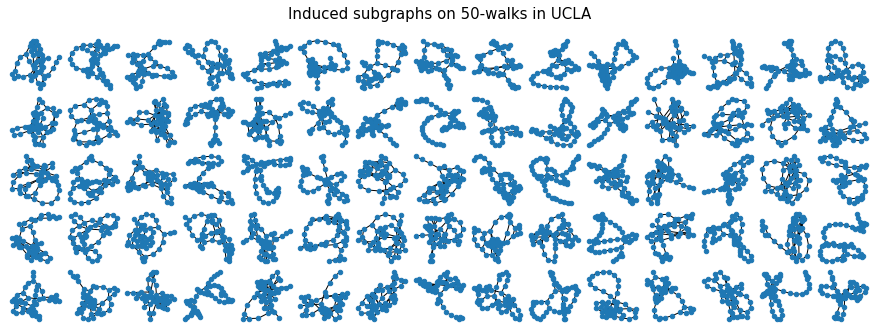

In [3]:
X, embs = G.get_patches(k=k, sample_size=2500, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [4]:
graph_list = generate_nxg(X)
print(f"num of graphs: {len(graph_list)}")

num of graphs: 2500


In [36]:
nodes = int(np.sqrt(X.shape[0]))
df = pd.DataFrame()
K = 3.5

for G in graph_list:
        
    if nx.is_connected(G):

        # Adjacency Matrix
        adj_mat = nx.to_numpy_array(G)
        temp = pd.DataFrame(np.array(nx.adjacency_matrix(G).todense().flatten('C')))
        
        # Kuramoto Dynamics
        model = Kuramoto(coupling=K, dt=0.01, T=5, n_nodes=nodes, half_sync=False)
        sim = model.run(adj_mat)
        arr = sim.T[-1]
        dyn = pd.DataFrame(sim[:,:].flatten(order='C')).T
        conc = pd.DataFrame(pd.Series(synchronization(arr)), columns=['Synchronized'])
        
        temp = pd.concat([temp, dyn, conc], axis=1)

        df = pd.concat([df, temp], ignore_index=True)
    
df

,0,1,2,3,4,5,6,7,8,9,...,24991,24992,24993,24994,24995,24996,24997,24998,24999,Synchronized
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.603911,0.607744,0.611574,0.615401,0.619224,0.623044,0.626860,0.630673,0.634483,False
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.419688,2.418656,2.417622,2.416586,2.415548,2.414509,2.413468,2.412426,2.411382,False
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.513762,0.512934,0.512103,0.511271,0.510437,0.509601,0.508763,0.507923,0.507081,False
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.425904,0.424706,0.423512,0.422322,0.421137,0.419956,0.418778,0.417605,0.416436,False
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.620632,5.617938,5.615230,5.612507,5.609771,5.607024,5.604266,5.601497,5.598720,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.059816,4.064891,4.069985,4.075096,4.080224,4.085369,4.090530,4.095706,4.100897,False
2496,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.009092,6.008161,6.007232,6.006305,6.005380,6.004457,6.003536,6.002616,6.001699,True
2497,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.566348,1.568203,1.570045,1.571872,1.573686,1.575487,1.577275,1.579050,1.580812,True
2498,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.281413,1.277345,1.273279,1.269216,1.265154,1.261095,1.257039,1.252984,1.248932,False


In [12]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.0808


In [13]:
X_true = df[df['Synchronized'] == True].drop(['Synchronized'], axis=1).values.astype('float32').T
X_false = df[df['Synchronized'] == False].drop(['Synchronized'], axis=1).values.astype('float32').T

In [18]:
W_true, H_true = ALS(X = X_true, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 100, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 100, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

  2%|▊                                          | 2/100 [00:00<00:25,  3.79it/s]

iteration 0, reconstruction error 243843840.101018


 11%|████▌                                     | 11/100 [00:02<00:23,  3.74it/s]

iteration 10, reconstruction error 70667204.595463


 21%|████████▊                                 | 21/100 [00:05<00:19,  4.04it/s]

iteration 20, reconstruction error 67761372.278403


 31%|█████████████                             | 31/100 [00:07<00:20,  3.43it/s]

iteration 30, reconstruction error 51914626.845843


 42%|█████████████████▋                        | 42/100 [00:10<00:14,  3.93it/s]

iteration 40, reconstruction error 44938938.120557


 51%|█████████████████████▍                    | 51/100 [00:12<00:13,  3.73it/s]

iteration 50, reconstruction error 41524799.216395


 61%|█████████████████████████▌                | 61/100 [00:15<00:10,  3.81it/s]

iteration 60, reconstruction error 39419326.283030


 71%|█████████████████████████████▊            | 71/100 [00:17<00:08,  3.58it/s]

iteration 70, reconstruction error 37878562.982000


 81%|██████████████████████████████████        | 81/100 [00:20<00:04,  4.01it/s]

iteration 80, reconstruction error 36734548.080705


 91%|██████████████████████████████████████▏   | 91/100 [00:22<00:02,  3.75it/s]

iteration 90, reconstruction error 35915707.406235


100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.08it/s]




###########################
Shape of W_true: (92500, 16)
###########################




  1%|▍                                          | 1/100 [00:04<06:58,  4.23s/it]

iteration 0, reconstruction error 2726473709.665702


 11%|████▌                                     | 11/100 [00:28<04:05,  2.76s/it]

iteration 10, reconstruction error 819062154.350371


 21%|████████▊                                 | 21/100 [00:51<03:12,  2.44s/it]

iteration 20, reconstruction error 864753680.424453


 31%|█████████████                             | 31/100 [01:14<02:52,  2.49s/it]

iteration 30, reconstruction error 862764982.640161


 41%|█████████████████▏                        | 41/100 [01:37<02:25,  2.47s/it]

iteration 40, reconstruction error 849309342.130079


 51%|█████████████████████▍                    | 51/100 [02:01<02:04,  2.54s/it]

iteration 50, reconstruction error 788106627.856620


 61%|█████████████████████████▌                | 61/100 [02:24<01:38,  2.51s/it]

iteration 60, reconstruction error 673395692.392096


 71%|█████████████████████████████▊            | 71/100 [02:48<01:21,  2.82s/it]

iteration 70, reconstruction error 586187480.072296


 81%|██████████████████████████████████        | 81/100 [03:12<00:47,  2.52s/it]

iteration 80, reconstruction error 544973235.802019


 91%|██████████████████████████████████████▏   | 91/100 [03:35<00:22,  2.46s/it]

iteration 90, reconstruction error 522451635.284209


100%|█████████████████████████████████████████| 100/100 [03:56<00:00,  2.36s/it]



###########################
Shape of W_false: (92500, 16)
###########################




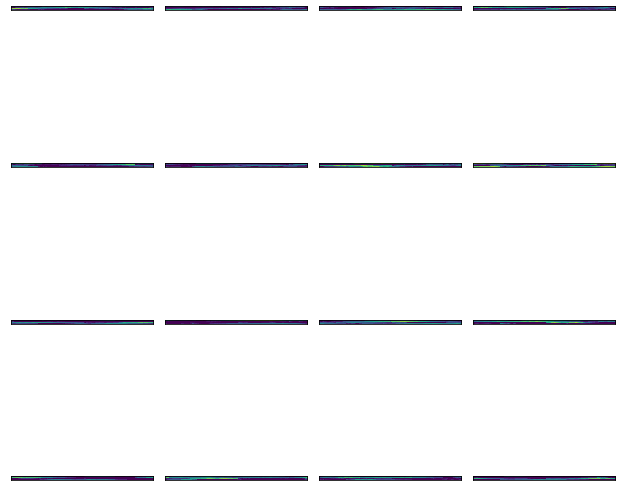

In [21]:
display_dictionary(W = W_true,
                   dictionary_shape=(50, 1850),
                   # save_name = save_folder + ntwk_nonumber + "_Dictionary_True",
                   figsize = [10,10])